**Installation des librairies**

In [ ]:
!pip install kneed tslearn hdbscan scikit-learn-extra scikit-fuzzy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
import io as io
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MaxAbsScaler
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MaxAbsScaler
import requests
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 80.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039188 sha256=9e86aa340223dba38d8b8c4f91285b6469cc52a4aebbdc8839dadd559169a9c9
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=68a96dfe2

**Chargement des données :**

In [ ]:
url = 'https://raw.githubusercontent.com/a-djamai/clustering_temp/main/X.txt'
response = requests.get(url)
X = pd.read_csv(io.StringIO(response.text), sep=' ', header=None, dtype=np.float32)
url = 'https://raw.githubusercontent.com/a-djamai/clustering_temp/main/APPART.txt'
response = requests.get(url)
APPART = pd.read_csv(io.StringIO(response.text), sep=' ', header=None, dtype=np.float32)

url = 'https://raw.githubusercontent.com/a-djamai/clustering_temp/main/JOUR.txt'
response = requests.get(url)
JOUR = pd.read_csv(io.StringIO(response.text), sep=' ', header=None, dtype=np.float32)


**Construction de la table de données:**

In [ ]:
X = np.array(X)
APPART = np.array(APPART)
JOUR = np.array(JOUR)
result_rows = []
row_labels = []
col_labels = []

for appart in range(1, 101):
    rows_for_appart = []
    for jour in range(1, 92):
        mask = (APPART == appart) & (JOUR == jour)
        rows_for_value = X[mask.all(axis=1)]
        rows_for_appart.append(rows_for_value)


    result_rows.append(np.concatenate(rows_for_appart, axis=1))
    row_labels.append(f'APPART_{appart}')
for jour in range(1, 92) :
  for step in range(0,48):
    col_labels.append(f'JOUR_{jour}_{step}')
result_array = np.concatenate(result_rows, axis=0)



**Aperçu:**

In [ ]:
df = pd.DataFrame(result_array, index=row_labels, columns=col_labels)
print(df.head())

          JOUR_1_0  JOUR_1_1  JOUR_1_2  JOUR_1_3  JOUR_1_4  JOUR_1_5  \
APPART_1 -1.786785 -1.759306 -1.731826 -1.657497 -1.504801 -1.303554   
APPART_2 -1.696926 -1.589682 -1.482438 -1.438186 -1.504610 -1.668164   
APPART_3  0.152293 -0.001868 -0.156029 -0.260148 -0.283644 -0.273770   
APPART_4 -0.951338 -1.038791 -1.126245 -1.259050 -1.456028 -1.629866   
APPART_5 -1.117863 -1.209420 -1.300977 -1.335880 -1.282855 -1.212149   

          JOUR_1_6  JOUR_1_7  JOUR_1_8  JOUR_1_9  ...  JOUR_91_38  JOUR_91_39  \
APPART_1 -1.099353 -0.939600 -0.834307 -0.642136  ...    0.806520    0.842348   
APPART_2 -1.880164 -2.012606 -1.950127 -1.707242  ...    0.816715    0.736486   
APPART_3 -0.282275 -0.301053 -0.309397 -0.296038  ...    0.744458    0.848834   
APPART_4 -1.693202 -1.664615 -1.575958 -1.406233  ...    0.487786    0.574832   
APPART_5 -1.186737 -1.139009 -0.997874 -0.808915  ...    0.674229    0.712476   

          JOUR_91_40  JOUR_91_41  JOUR_91_42  JOUR_91_43  JOUR_91_44  \
APPART_1

**Visualiser la consommation de APPART_1:**


In [ ]:
import seaborn as sns
appart_1_series = df.loc['APPART_1']
plt.figure(figsize=(45, 6))
sns.lineplot(appart_1_series)

# **Partie 1: Transformation en données catégorielles:**

In [ ]:
reshaped_data = df.values.reshape(-1, 48)
print(reshaped_data.shape)
prep = MaxAbsScaler()
scaled_data = prep.fit_transform(reshaped_data)

(9100, 48)


### **Tester les différentes méthodes de clustering sur notre dataset:**

### Kmeans


**Déterminer le nombre optimal de clusters**

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_data)
    Sum_of_squared_distances.append(km.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

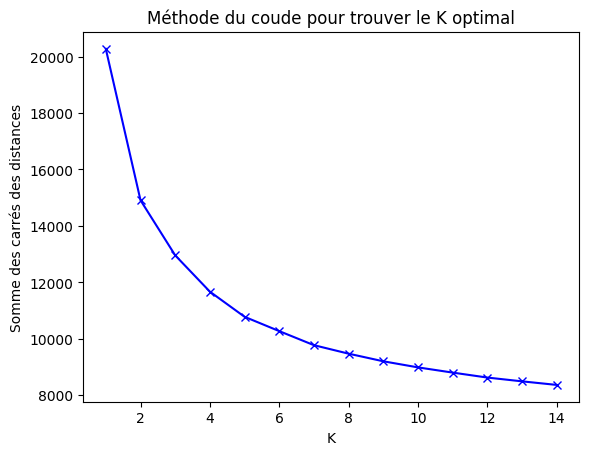

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Somme des carrés des distances')
plt.title('Méthode du coude pour trouver le K optimal')
plt.show()


Dans le graphique ci-dessus, le coude est à k = 5, ce qui indique que le k optimal pour cet ensemble de données est 5

In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### KMedoids (PAM)

In [ ]:
kmedoids = KMedoids(n_clusters=num_clusters,metric='euclidean',method='pam', random_state=0).fit(scaled_data)

### Fuzzy k-means

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(scaled_data.T, c=4, m=2, error=0.005, maxiter=1000)
fuzzy_KMeans_labels = np.argmax(u, axis=0)

### DBSCAN

**Chercher la bonne valeur d'epsilon**

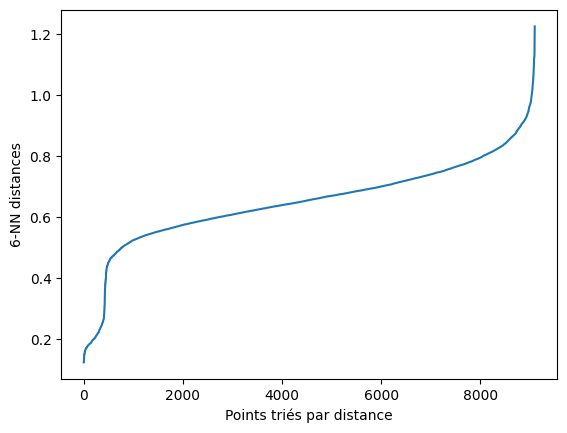

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.xlabel('Points triés par distance')
plt.ylabel('6-NN distances')
plt.show()


il semble que la valeur optimale de ε soit d'environ 0.97

In [ ]:
dbscan = DBSCAN(eps=0.97,min_samples = 6).fit(scaled_data)

### HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
hdbscan = clusterer.fit(scaled_data)

## Evaluer les methodes

In [ ]:
labels = {
  "kmeans": kmeans.labels_,
  "kmedoids": kmedoids.labels_,
  "fuzzy_kmeans":fuzzy_KMeans_labels,
  "dbscan": dbscan.labels_,
  "hdbscan": hdbscan.labels_
}


for method in ['kmeans','kmedoids','fuzzy_kmeans','dbscan','hdbscan']:

    print(method, silhouette_score(scaled_data, labels[method]))
########################################################################

kmeans 0.1905271
kmedoids 0.17363906
fuzzy_kmeans 0.13148606
dbscan 0.13718586
hdbscan 0.10603999


On remarque que KMeans donne les meilleurs résultats

## Generer Y avec Kmeans

In [ ]:
cluster_labels = kmeans.fit_predict(scaled_data)
Y = pd.DataFrame(cluster_labels.reshape(100, 91), index=df.index, columns = [f'JOUR_{X+1}' for X in range(91)])
print(Y)

for cluster in range(5):
  sum = 0
  n = 0
  for i in range(len(cluster_labels)):
    if cluster == cluster_labels[i]:
      sum += reshaped_data[i]
      n += 1
  moy = sum.sum() / n
  print(f"Moyenne Cluster {cluster} = {moy}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


            JOUR_1  JOUR_2  JOUR_3  JOUR_4  JOUR_5  JOUR_6  JOUR_7  JOUR_8  \
APPART_1         3       3       3       1       3       2       2       3   
APPART_2         1       1       3       1       3       0       0       3   
APPART_3         4       4       3       3       3       2       4       3   
APPART_4         3       3       3       3       3       2       2       3   
APPART_5         3       3       3       3       3       2       2       3   
...            ...     ...     ...     ...     ...     ...     ...     ...   
APPART_96        3       3       3       1       3       2       2       3   
APPART_97        3       3       1       3       3       2       2       3   
APPART_98        3       3       3       3       3       2       2       3   
APPART_99        3       3       3       1       1       2       2       1   
APPART_100       0       3       3       3       1       0       1       1   

            JOUR_9  JOUR_10  ...  JOUR_82  JOUR_83  JOUR_84  JO

**Affichage:**

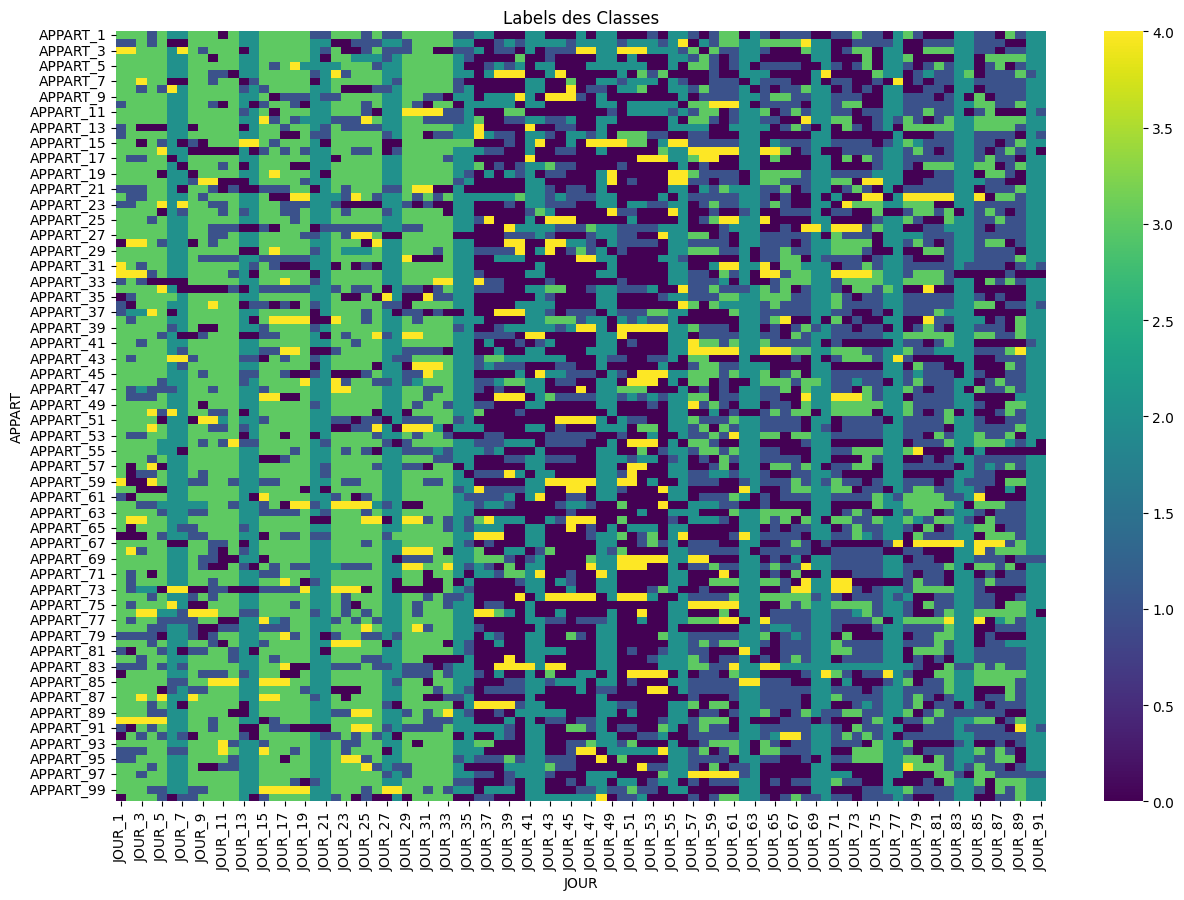

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(Y, cmap='viridis', annot=False, cbar=True)
plt.title('Labels des Classes')
plt.xlabel('JOUR')
plt.ylabel('APPART')
plt.show()

### Interpéter les classes obtenues ainsi que leurs centres associés.

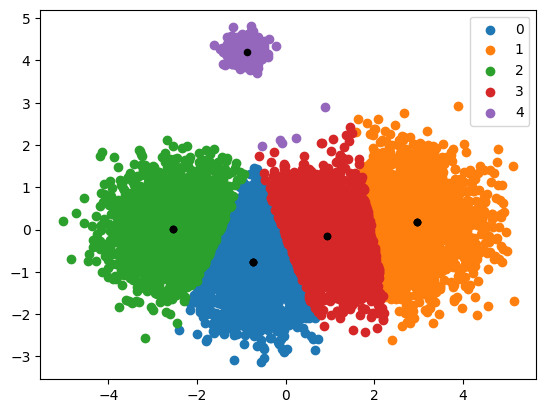

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
df = pca.fit_transform(X)
kmeans_for_plotting = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans_for_plotting.fit(df)

centroids = kmeans_for_plotting.cluster_centers_
label = kmeans_for_plotting.labels_
u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.legend()
plt.show()

# **Partie 2 : Classification des jours**

In [ ]:
Sum_of_squared_distances = []
prep = MaxAbsScaler()

scaled_data = prep.fit_transform(Y.transpose())
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_data)
    Sum_of_squared_distances.append(km.inertia_)

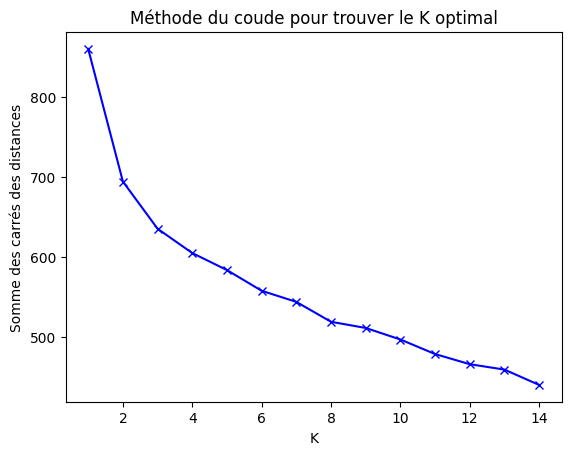

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Somme des carrés des distances')
plt.title('Méthode du coude pour trouver le K optimal')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler

prep = MaxAbsScaler()
kmeans = KMeans(n_clusters=4, random_state=0)

scaled_data = prep.fit_transform(Y.transpose())

cluster_labels = kmeans.fit_predict(scaled_data)
extended_arr = np.tile(cluster_labels, (100, 1)).T
print(extended_arr.shape)

Z = pd.DataFrame(extended_arr, index=Y.transpose().index, columns = Y.index)
print(Z.shape)
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster}")
    cluster_data = Y.transpose()[kmeans.labels_ == cluster]
    for i in range(cluster_data.shape[0]):
        print(cluster_data.index[i])
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(91, 100)
(91, 100)
Cluster 0
JOUR_59
JOUR_60
JOUR_61
JOUR_64
JOUR_65
JOUR_66
JOUR_67
JOUR_68
JOUR_71
JOUR_72
JOUR_73
JOUR_74
JOUR_75

Cluster 1
JOUR_36
JOUR_37
JOUR_38
JOUR_39
JOUR_40
JOUR_43
JOUR_44
JOUR_45
JOUR_46
JOUR_47
JOUR_50
JOUR_51
JOUR_52
JOUR_53
JOUR_54

Cluster 2
JOUR_6
JOUR_7
JOUR_13
JOUR_14
JOUR_20
JOUR_21
JOUR_27
JOUR_28
JOUR_34
JOUR_35
JOUR_41
JOUR_42
JOUR_48
JOUR_49
JOUR_55
JOUR_56
JOUR_57
JOUR_58
JOUR_62
JOUR_63
JOUR_69
JOUR_70
JOUR_76
JOUR_77
JOUR_78
JOUR_79
JOUR_80
JOUR_81
JOUR_82
JOUR_83
JOUR_84
JOUR_85
JOUR_86
JOUR_87
JOUR_88
JOUR_89
JOUR_90
JOUR_91

Cluster 3
JOUR_1
JOUR_2
JOUR_3
JOUR_4
JOUR_5
JOUR_8
JOUR_9
JOUR_10
JOUR_11
JOUR_12
JOUR_15
JOUR_16
JOUR_17
JOUR_18
JOUR_19
JOUR_22
JOUR_23
JOUR_24
JOUR_25
JOUR_26
JOUR_29
JOUR_30
JOUR_31
JOUR_32
JOUR_33



**Affichage:**

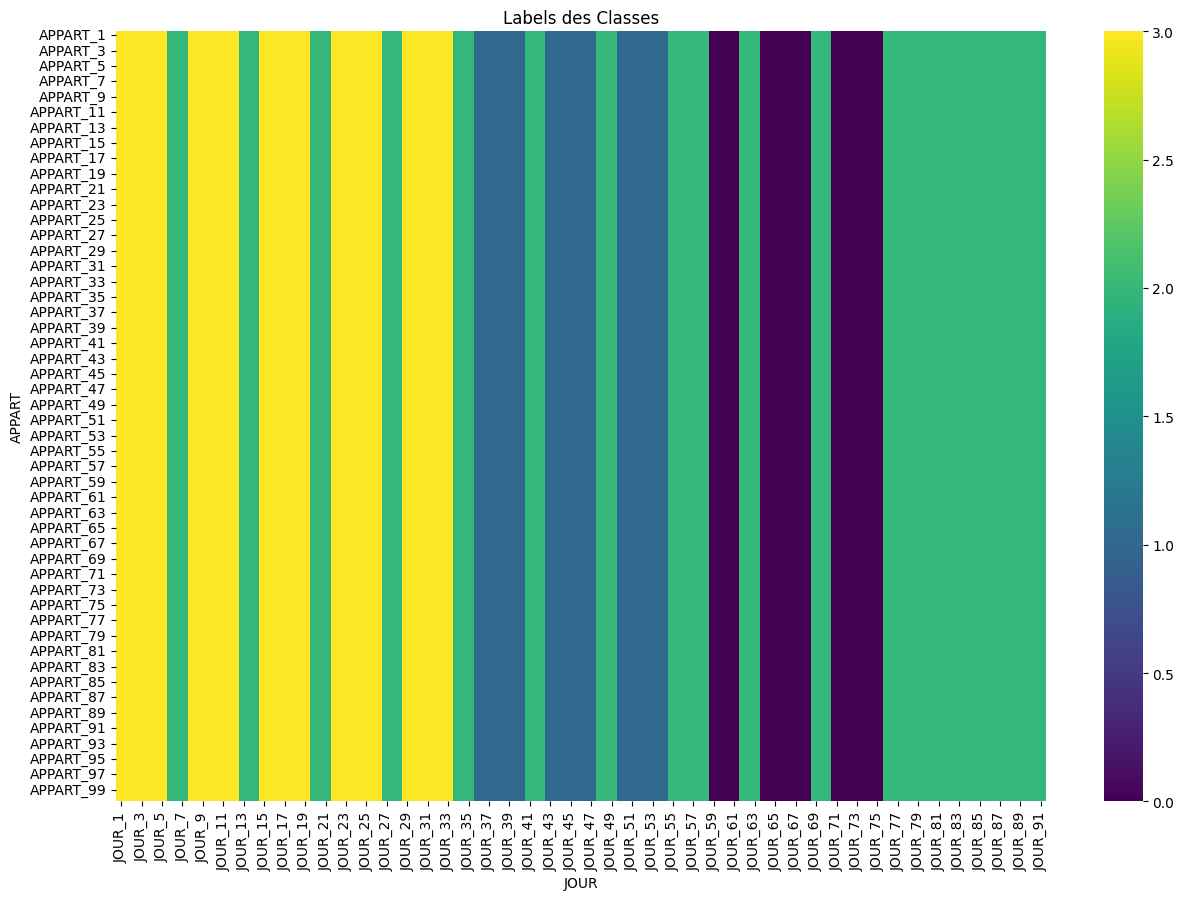

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(Z.transpose(), cmap='viridis', annot=False, cbar=True)

plt.title('Labels des Classes')
plt.xlabel('JOUR')
plt.ylabel('APPART')
plt.show()
